# Pipeline for High-z Radio Galaxies 12: Application of full pipeline for prediction

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
# import schemdraw
# from schemdraw import flow

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [12]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [13]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [14]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [15]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [16]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0.)

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

---

## Reading data

In [17]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [18]:
save_plot_flag      = False
load_models_flag    = True
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [19]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'

In [20]:
if used_area != 'S82':
    compare_A17_flag = False

In [21]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [22]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [23]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [24]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [25]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Discard minor features.

In [26]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [27]:
seed                                = 42

---

### Load models

In [28]:
if load_models_flag:
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_09_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_10_2022')  # to use on full sample
    redshift_reg_2  = pyr.load_model('models/regression_z_may_12_2022')  # to use on sources with predicted z >= 2

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [29]:
threshold_AGN   = 0.5
threshold_radio = 0.5

In [30]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_0': 'Score_gal', 'Score_1': 'Score_AGN'})

In [31]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})

In [32]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=3)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [33]:
redshift_lim    = 2.0
redshift_tol    = 0.1
full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=3)
filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim - redshift_tol)
full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
full_catalog_df = full_catalog_df.drop(columns=['Label'])
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

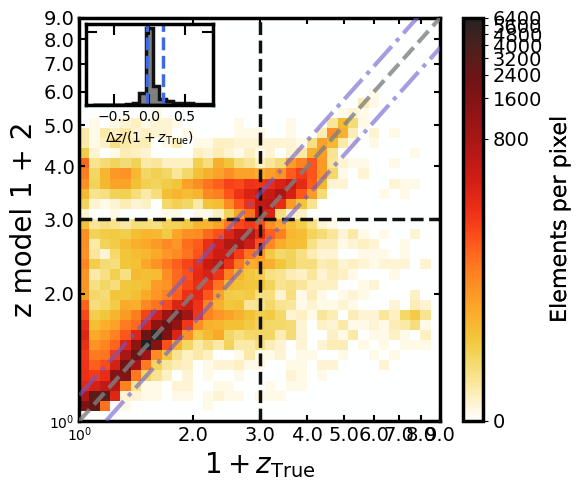

In [34]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=True)
ax1.axvline(x=(1 + redshift_lim), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim), ls='--', c='k', lw=2.5)
ax1.set_ylabel('z model 1 + 2', size=20)
plt.show()

In [35]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,6.729647e+06,6.729647e+06,6.729647e+06,6.729647e+06,93071.000000,6.729647e+06
mean,4.981605e-01,1.408276e-01,5.133969e-02,1.899401e-02,0.771065,1.232168e+00
std,5.634398e-02,3.478436e-01,2.206897e-01,1.365036e-01,0.754850,5.656474e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.004490,8.200000e-02
25%,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.257255,7.870000e-01
50%,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.550640,1.340000e+00
75%,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.003000,1.402000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.028330,4.872000e+00


Obtain intermediate metrics

In [36]:
filter_AGN_t       = np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_gal_AGN_t   = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_AGN_p       = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN)
filter_radio_p     = np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)
filter_radio_AGN_p = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN) & np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)

In [37]:
cm_AGN = np.array([[np.sum(np.array(full_catalog_df['class'] == 0) & np.array(full_catalog_df['Score_AGN'] <= threshold_AGN)),\
                    np.sum(np.array(full_catalog_df['class'] == 0) & np.array(full_catalog_df['Score_AGN'] >  threshold_AGN))],\
                   [np.sum(np.array(full_catalog_df['class'] == 1) & np.array(full_catalog_df['Score_AGN'] <= threshold_AGN)),\
                    np.sum(np.array(full_catalog_df['class'] == 1) & np.array(full_catalog_df['Score_AGN'] >  threshold_AGN))]])

In [38]:
cm_AGN_large = np.array([[np.sum(np.array(full_catalog_df['class'] == 0) & np.array(full_catalog_df['Score_AGN']    <= threshold_AGN)),\
                          np.sum(np.array(full_catalog_df['class'] == 0) & np.array(full_catalog_df['pred_class']   == 0.5)),\
                          np.sum(np.array(full_catalog_df['class'] == 0) & np.array(full_catalog_df['Score_AGN']    > threshold_AGN))],\
                         [np.sum(np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['Score_AGN']  <= threshold_AGN)),\
                          np.sum(np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df['class'] == 0.5) & np.array(full_catalog_df['Score_AGN']  > threshold_AGN))],\
                         [np.sum(np.array(full_catalog_df['class'] == 1) & np.array(full_catalog_df['Score_AGN']    <= threshold_AGN)),\
                          np.sum(np.array(full_catalog_df['class'] == 1) & np.array(full_catalog_df['pred_class']   == 0.5)),\
                          np.sum(np.array(full_catalog_df['class'] == 1) & np.array(full_catalog_df['Score_AGN']    > threshold_AGN))]])

In [39]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'Score_radio']  <= threshold_radio)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'Score_radio']  > threshold_radio))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'Score_radio']  <= threshold_radio)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'Score_radio']  > threshold_radio))]])

In [40]:
cm_radio_gal_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 0) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   <= threshold_radio)),\
                              np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 0) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   > threshold_radio))],\
                             [np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 1) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   <= threshold_radio)),\
                              np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 1) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   > threshold_radio))]])

In [41]:
sigma_mad_field            = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

In [42]:
sigma_mad_field_gal_AGN    = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
sigma_nmad_field_gal_AGN   = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
sigma_z_field_gal_AGN      = sigma_z(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
sigma_z_norm_field_gal_AGN = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'], full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
out_frac_field_gal_AGN     = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'], full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])

Plot histograms for scores.

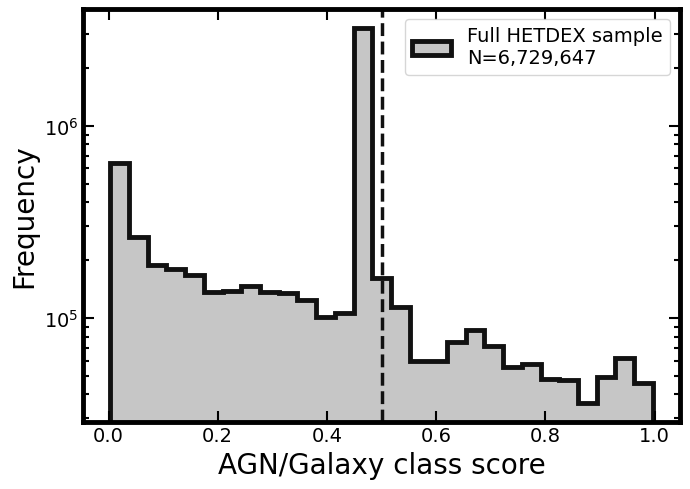

In [43]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(np.isfinite(full_catalog_df.loc[:, 'Score_AGN']))

ax1.hist(full_catalog_df.loc[:, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Full {used_area} sample\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_AGN_scores_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

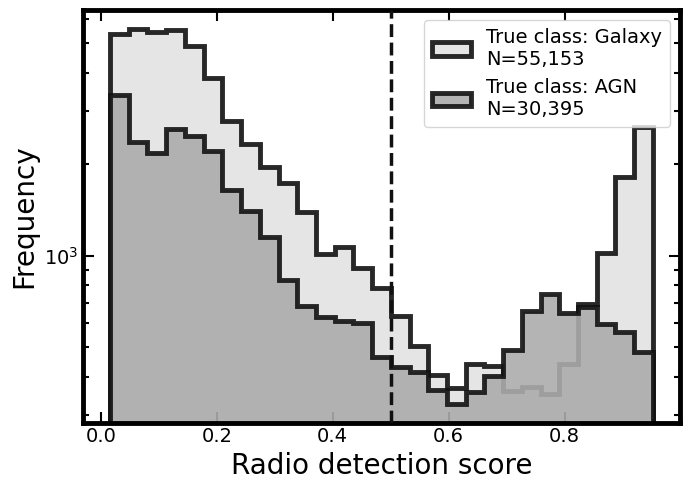

In [44]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_true_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

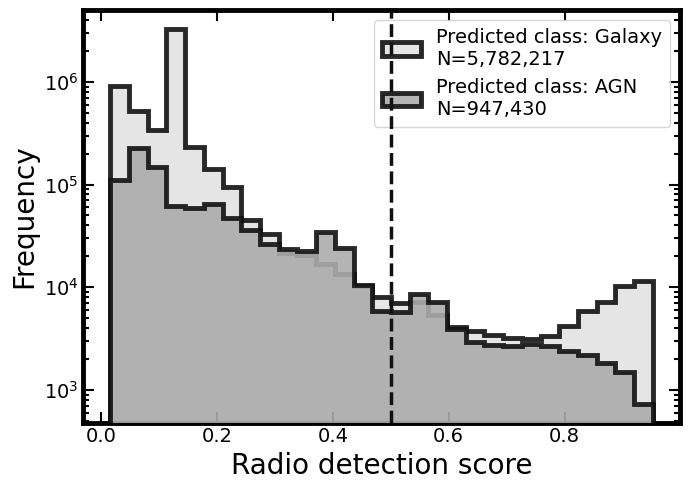

In [45]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=9)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_predicted_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

Plot histograms for predicted and original redshifts.

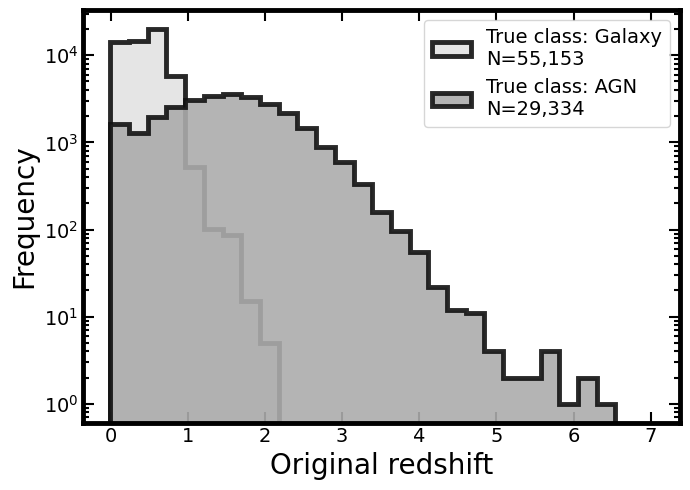

In [46]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_original_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

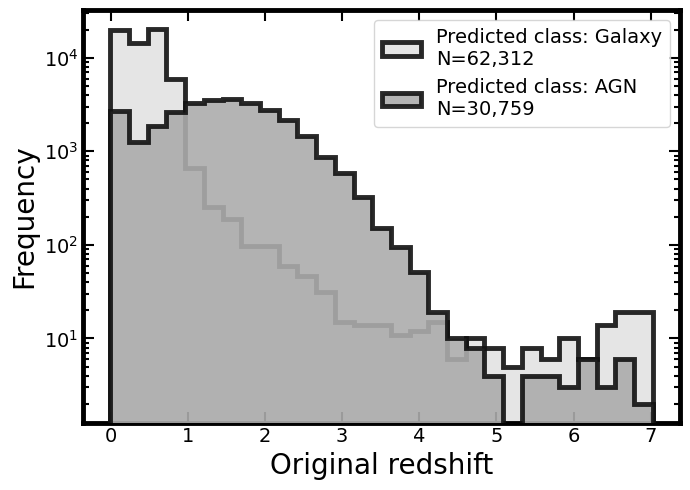

In [47]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_true_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

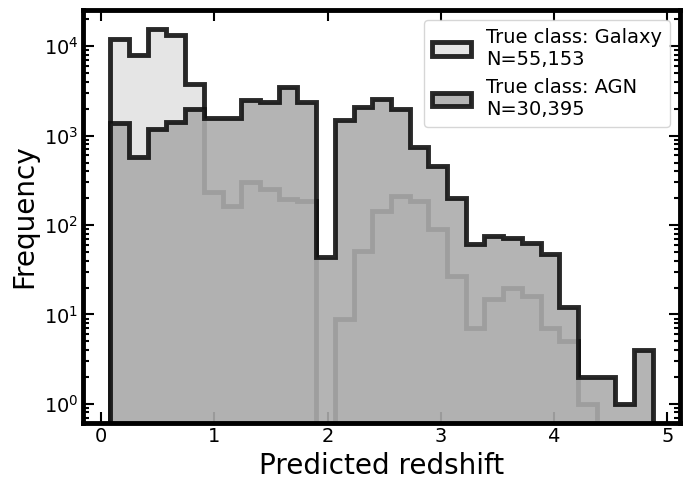

In [48]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

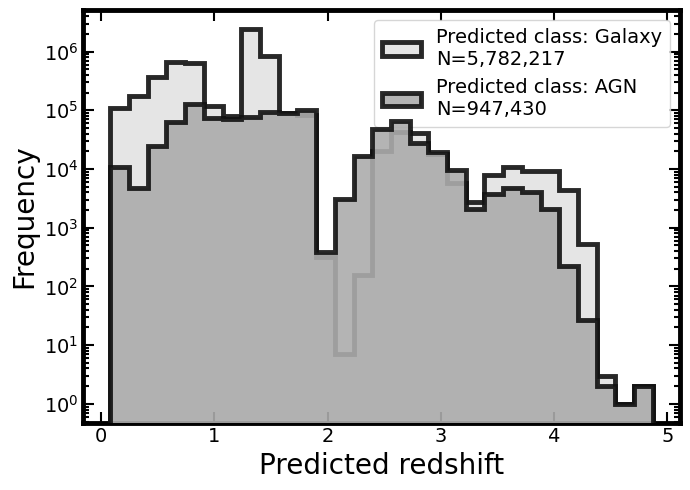

In [49]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

### Select sources predicted to be Radio AGN

In [50]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
total_size              = len(full_catalog_df)
num_AGN_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1))
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [51]:
filter_radio_AGN_p_full = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN) & np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)
num_AGN_p_full          = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN))
num_gal_p_full          = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN))
num_radio_p_full        = np.sum(np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio))
num_radio_AGN_p_full    = np.sum(filter_radio_AGN_p_full)

In [52]:
full_catalog_df         = full_catalog_df.loc[filter_radio_AGN_t]

In [53]:
filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN) & np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)
num_AGN_p               = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN))
num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN))
num_radio_p             = np.sum(np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio))
num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

In [54]:
full_catalog_df         = full_catalog_df.loc[filter_radio_AGN_p]

In [55]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,6458.0,6458.0,6458.0,6458.0,6316.000000,6458.000000
mean,1.0,1.0,1.0,1.0,1.205705,1.194661
std,0.0,0.0,0.0,0.0,0.874274,0.834631
min,1.0,1.0,1.0,1.0,0.002000,0.082000
25%,1.0,1.0,1.0,1.0,0.452750,0.509000
50%,1.0,1.0,1.0,1.0,1.104500,1.048500
75%,1.0,1.0,1.0,1.0,1.844000,1.738000
max,1.0,1.0,1.0,1.0,5.800000,4.872000


Add individual metrics for redshift

In [56]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [57]:
str_0_t   = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t   = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t   = f'{num_AGN_t:,} are confirmed to be AGN. And, from the AGN,\n'
str_3_t   = f'{num_radio_AGN_t:,} are detected in radio.'

str_0_p_f = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_p_f = f'{num_gal_p_full:,} are predicted to be galaxies. On the other side,\n'
str_2_p_f = f'{num_AGN_p_full:,} are predicted to be AGN. And, from the predicted AGN,\n'
str_3_p_f = f'{num_radio_AGN_p_full:,} are predicted to be detected in radio.'

str_0_p   = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p   = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p   = f'{num_AGN_p:,} are predicted to be AGN. And, from the predicted AGN,\n'
str_3_p   = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

In [58]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p_f + str_1_p_f + str_2_p_f + str_3_p_f)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)

------------------------------------------------------------
Out of 6,729,647 initial sources in HETDEX,
55,153 are confirmed to be galaxies. On the other side,
30,395 are confirmed to be AGN. And, from the AGN,
9,894 are detected in radio.
------------------------------------------------------------
Out of 6,729,647 initial sources in HETDEX,
5,782,217 are predicted to be galaxies. On the other side,
947,430 are predicted to be AGN. And, from the predicted AGN,
48,082 are predicted to be detected in radio.
------------------------------------------------------------
Out of 9,894 initial radio-detected AGN in HETDEX,
807 are predicted to be galaxies. On the other side,
9,087 are predicted to be AGN. And, from the predicted AGN,
6,458 are predicted to be detected in radio.
------------------------------------------------------------


In [59]:
cols_4_table = show_columns = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z', 'Delta_z_N']

In [60]:
display(full_catalog_df.loc[:, cols_4_table].sort_values(by='pred_Z', ascending=False).head(10))

,RA_ICRS,DE_ICRS,Name,TYPE,band_num,class,pred_class,radio_detect,pred_radio,Z,pred_Z,Delta_z_N
4840563,203.594269,47.842628,J133422.63+475033.4,QX,10,1.0,1,1,1,4.958,4.872,-0.014
1125556,180.153030,46.313980,J120036.73+461850.3,Q,11,1.0,1,1,1,4.745,4.551,-0.034
6483557,182.891861,48.709946,J121134.04+484235.8,Q,11,1.0,1,1,1,4.540,4.508,-0.006
2470555,208.178101,49.512688,J135242.75+493045.6,Q,10,1.0,1,1,1,4.680,4.383,-0.052
4880105,222.583801,55.621254,J145020.11+553716.5,Q,11,1.0,1,1,1,4.230,4.375,0.028
4880210,208.127121,53.185715,J135230.51+531108.5,Q,11,1.0,1,1,1,4.223,4.191,-0.006
5632575,165.507919,53.653446,J110201.91+533912.4,QR,11,1.0,1,1,1,4.310,4.168,-0.027
4870588,187.718704,51.094986,J123052.49+510541.9,Q,11,1.0,1,1,1,4.097,4.156,0.012
5816058,210.399948,51.953251,J140135.99+515711.7,Q,11,1.0,1,1,1,4.148,4.151,0.001
3992021,223.137207,49.891617,J145232.93+495329.8,Q,11,1.0,1,1,1,3.885,4.046,0.033


In [61]:
display(full_catalog_df.loc[:, cols_4_table].sort_values(by='Z', ascending=False).head(10))

,RA_ICRS,DE_ICRS,Name,TYPE,band_num,class,pred_class,radio_detect,pred_radio,Z,pred_Z,Delta_z_N
5920869,206.358017,56.072796,J134525.93+560422.0,R,9,1.0,1,1,1,5.800,0.881,-0.723
4873366,172.824844,51.006256,J113117.96+510022.5,R,10,1.0,1,1,1,5.700,3.902,-0.268
4840563,203.594269,47.842628,J133422.63+475033.4,QX,10,1.0,1,1,1,4.958,4.872,-0.014
1125556,180.153030,46.313980,J120036.73+461850.3,Q,11,1.0,1,1,1,4.745,4.551,-0.034
5721848,190.627365,54.382648,J124230.57+542257.5,QR,10,1.0,1,1,1,4.734,1.554,-0.555
2470555,208.178101,49.512688,J135242.75+493045.6,Q,10,1.0,1,1,1,4.680,4.383,-0.052
4705430,206.930389,49.939240,J134743.30+495621.3,QX,14,1.0,1,1,1,4.564,1.096,-0.623
6483557,182.891861,48.709946,J121134.04+484235.8,Q,11,1.0,1,1,1,4.540,4.508,-0.006
4891800,185.256058,48.603718,J122101.45+483613.4,Q,11,1.0,1,1,1,4.417,4.035,-0.071
5632575,165.507919,53.653446,J110201.91+533912.4,QR,11,1.0,1,1,1,4.310,4.168,-0.027


Confusion matrix for AGN/galaxy prediction on all sources

In [62]:
MCC_AGN              = MCC_from_CM(cm_AGN)
ACC_AGN              = ACC_from_CM(cm_AGN)
F1_AGN               = F1_from_CM(cm_AGN)
Recall_AGN           = Recall_from_CM(cm_AGN)

Confusion matrix for radio detection prediction on all predicted AGN

In [63]:
MCC_radio            = MCC_from_CM(cm_radio)
ACC_radio            = ACC_from_CM(cm_radio)
F1_radio             = F1_from_CM(cm_radio)
Recall_radio         = Recall_from_CM(cm_radio)

Confusion matrix for radio detection prediction on all confirmed AGN and galaxies that are predicted to be AGN

In [64]:
MCC_radio_gal_AGN    = MCC_from_CM(cm_radio_gal_AGN)
ACC_radio_gal_AGN    = ACC_from_CM(cm_radio_gal_AGN)
F1_radio_gal_AGN     = F1_from_CM(cm_radio_gal_AGN)
Recall_radio_gal_AGN = Recall_from_CM(cm_radio_gal_AGN)

In [65]:
# sigma_mad_field    = sigma_mad(full_catalog_df.loc[:, 'Z'],    full_catalog_df.loc[:, 'pred_Z'])
# sigma_nmad_field   = sigma_nmad(full_catalog_df.loc[:, 'Z'],   full_catalog_df.loc[:, 'pred_Z'])
# sigma_z_field      = sigma_z(full_catalog_df.loc[:, 'Z'],      full_catalog_df.loc[:, 'pred_Z'])
# sigma_z_norm_field = sigma_z_norm(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'])
# out_frac_field     = outlier_frac(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'])

Print metrics

In [66]:
print('Metrics for AGN prediction on all sources')
print(f'Matthews Correlation Coefficient, MCC = {MCC_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_AGN:.4f}')

Metrics for AGN prediction on all sources
Matthews Correlation Coefficient, MCC = 0.9464
Accuracy,                         ACC = 0.9755
F-1 Score,                         F1 = 0.9650
Recall,                        Recall = 0.9503


In [67]:
print('Metrics for radio detection prediction on all predicted AGN')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio:.4f}')
print(f'Recall,                        Recall = {Recall_radio:.4f}')

Metrics for radio detection prediction on all predicted AGN
Matthews Correlation Coefficient, MCC = 0.4295
Accuracy,                         ACC = 0.9169
F-1 Score,                         F1 = 0.4433
Recall,                        Recall = 0.3357


In [68]:
print('Metrics for radio detection prediction on all confirmed AGN and galaxies that are predicted to be AGN')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_gal_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_gal_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_gal_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_radio_gal_AGN:.4f}')

Metrics for radio detection prediction on all confirmed AGN and galaxies that are predicted to be AGN
Matthews Correlation Coefficient, MCC = 0.7577
Accuracy,                         ACC = 0.8968
F-1 Score,                         F1 = 0.8122
Recall,                        Recall = 0.7104


In [69]:
print('Metrics for redshift prediction on all predicted radio AGN')
print(f'Sigma MAD                             = {sigma_mad_field:.4f}')
print(f'Sigma NMAD,                           = {sigma_nmad_field:.4f}')
print(f'Sigma z,                              = {sigma_z_field:.4f}')
print(f'Sigma z normalized,                   = {sigma_z_norm_field:.4f}')
print(f'Outlier fraction,                     = {out_frac_field:.4f}')

Metrics for redshift prediction on all predicted radio AGN
Sigma MAD                             = 0.1110
Sigma NMAD,                           = 0.0556
Sigma z,                              = 0.1411
Sigma z normalized,                   = 0.0652
Outlier fraction,                     = 0.1019


In [70]:
print('Metrics for redshift prediction on all confirmed AGN and galaxies that are predicted to be radio AGN')
print(f'Sigma MAD                             = {sigma_mad_field_gal_AGN:.4f}')
print(f'Sigma NMAD,                           = {sigma_nmad_field_gal_AGN:.4f}')
print(f'Sigma z,                              = {sigma_z_field_gal_AGN:.4f}')
print(f'Sigma z normalized,                   = {sigma_z_norm_field_gal_AGN:.4f}')
print(f'Outlier fraction,                     = {out_frac_field_gal_AGN:.4f}')

Metrics for redshift prediction on all confirmed AGN and galaxies that are predicted to be radio AGN
Sigma MAD                             = 0.1080
Sigma NMAD,                           = 0.0545
Sigma z,                              = 0.2872
Sigma z normalized,                   = 0.1262
Outlier fraction,                     = 0.0935


Plot predictions

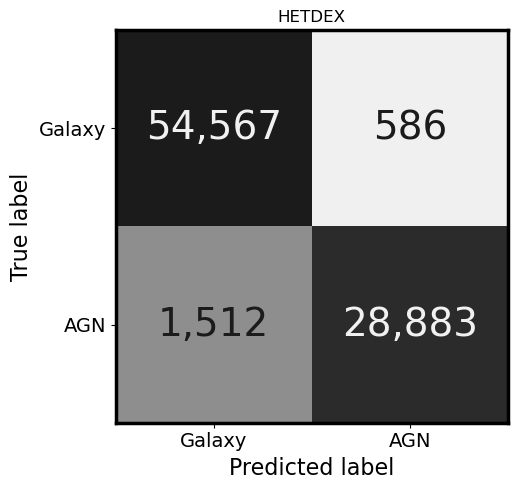

In [71]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

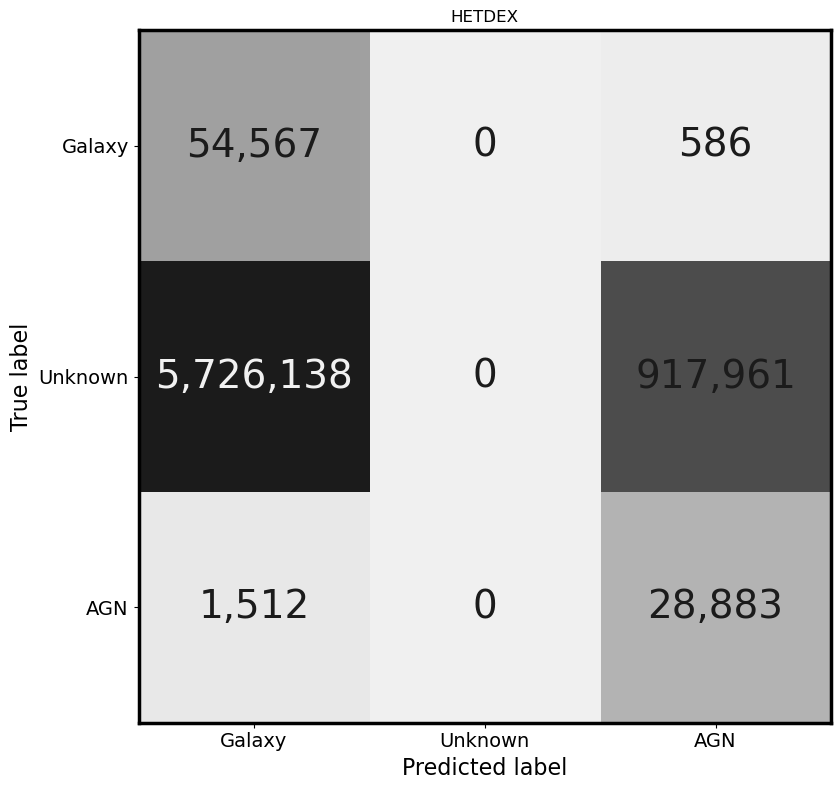

In [72]:
fig             = plt.figure(figsize=(9,8))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN_large, title=used_area, axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_all_classes_{used_area}.pdf', bbox_inches='tight')
plt.show()

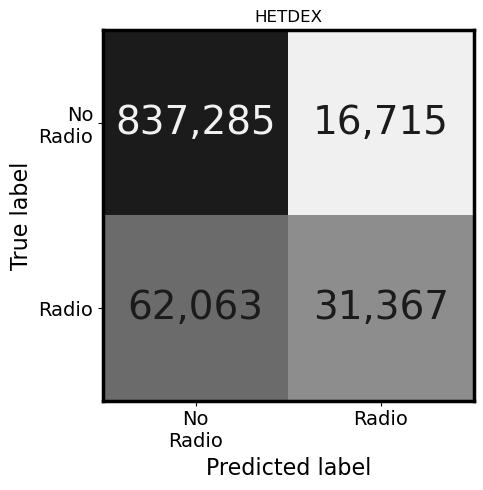

In [73]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

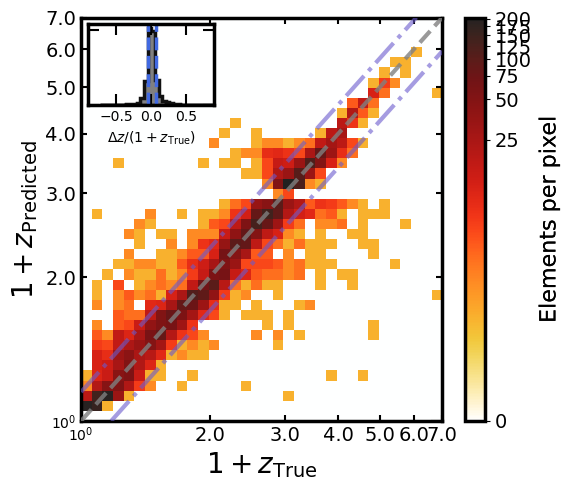

In [74]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

---

#### Additional test with data from Ananna et al., 2017

In [75]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(cat_path + file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [76]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=3)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=3)
    redshift_lim    = 2.0
    redshift_tol    = 0.1
    full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=3)
    filter_pred_z_A17   = (full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim - redshift_tol)) &\
                        (full_catalog_A17_df.loc[:, 'pred_Z'] < full_catalog_A17_df.loc[:, 'Label'])
    full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
    full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
    full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=3)

In [77]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7,5.0))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='log')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    if save_plot_flag:
        plt.savefig(f'plots/hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    fig.tight_layout()

In [78]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'radio_detect'] == 1)]

In [79]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [80]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'radio_detect', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [81]:
if compare_A17_flag:
    sigma_mad_field_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_field_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_field_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_field_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_field_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [82]:
if compare_A17_flag:
    print('Metrics for redshift prediction on AGN from Ananna et al., 2017')
    print(f'Sigma MAD                             = {sigma_mad_field_A17:.4f}')
    print(f'Sigma NMAD,                           = {sigma_nmad_field_A17:.4f}')
    print(f'Sigma z,                              = {sigma_z_field_A17:.4f}')
    print(f'Sigma z normalized,                   = {sigma_z_norm_field_A17:.4f}')
    print(f'Outlier fraction,                     = {out_frac_field_A17:.4f}')

In [83]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(f'plots/compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()